In [1]:
import numpy as np

## Import data

In [2]:
# Import data
train = np.load('train_data_abs_coord.npy').astype(float)
val = np.load('test_data_abs_coord.npy').astype(float)
print((train.shape))

(60000, 117, 4)


## Define VAE

In [3]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, CuDNNLSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives


def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std=1.):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = CuDNNLSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_sigma) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = CuDNNLSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True,activation='linear')

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss
    opt=Adam(lr=0.0001)
    vae.compile(optimizer=opt, loss=vae_loss)
    
    return vae, encoder, generator

Using TensorFlow backend.


In [12]:
from keras.callbacks import TensorBoard,ModelCheckpoint    
from time import time


_,timesteps,input_dim=train.shape
# Hyper paramters for network
intermediate_dim = 512
latent_dim = 128
batch_size = 500
vae, encoder, generator = create_lstm_vae(  input_dim, 
                                            timesteps, 
                                            batch_size, 
                                            intermediate_dim, 
                                            latent_dim,
                                            epsilon_std=1.)
# Hyper parmaeters for training
batch_size = batch_size
epochs = 23
time=time()
Name="tewst"#f"lat:{latent_dim}-inter:{intermediate_dim}-time{time}."
os.getcwd()
tensorboard = TensorBoard(log_dir="logs/"+Name)
modelcheckpoint = ModelCheckpoint("model/"+Name+"epo:{epoch:02d}-val_loss{val_loss:.2f}.hdf5",monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks =[tensorboard,modelcheckpoint]


# Training with abs coord (intermediate_dim = 512) fairly succesfull up to 23 epochs
                        #(latent_dim = 128)
                        #(batch_size = 500)

vae.fit( x = train, y = train, batch_size = batch_size , epochs = epochs, validation_data=(val, val),callbacks=callbacks)

Train on 60000 samples, validate on 10000 samples
Epoch 1/23
60000/60000 [==============================] - 58s 961us/step - loss: 3.9897 - val_loss: 4.1704
Epoch 2/23
60000/60000 [==============================] - 55s 911us/step - loss: 4.0747 - val_loss: 3.8765
Epoch 3/23
60000/60000 [==============================] - 55s 909us/step - loss: 3.8618 - val_loss: 3.7402
Epoch 4/23
60000/60000 [==============================] - 55s 911us/step - loss: 3.7359 - val_loss: 3.6132
Epoch 5/23
60000/60000 [==============================] - 55s 915us/step - loss: 3.5639 - val_loss: 3.4019
Epoch 6/23
60000/60000 [==============================] - 55s 915us/step - loss: 3.4578 - val_loss: 3.3830
Epoch 7/23
60000/60000 [==============================] - 55s 917us/step - loss: 3.4707 - val_loss: 3.4195
Epoch 8/23
60000/60000 [==============================] - 55s 916us/step - loss: 3.4565 - val_loss: 3.3812
Epoch 9/23
60000/60000 [==============================] - 55s 915us/step - loss: 3.4724 - val_

In [ ]:
vae.fit( x = train, y = train, batch_size = batch_size , epochs = epochs, validation_data=(val, val))

In [13]:
from keras.models import load_model
import keras.losses
# VAE Z layer
z_mean = Dense(latent_dim)
z_log_sigma = Dense(latent_dim)
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.mse(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    loss = xent_loss + kl_loss
    return loss
keras.losses.vae_loss = vae_loss
#vae=load_model('model/latent_dim128-intermediate_dim512-time1540355769.8443556.weights-23-3.41.hdf5', custom_objects={'vae_loss': vae_loss})
predicted=vae.predict(train[0:batch_size],batch_size=batch_size)


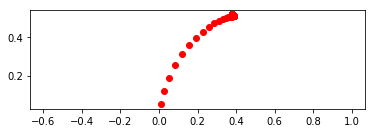

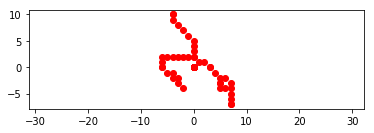

In [21]:
import matplotlib.pyplot as plt
from keras.models import load_model
b=89
plt.close()
predicted_abs=np.cumsum(predicted,axis=0)
plt.subplot(211)
#plt.plot(np.cumsum(predicted[b,:,0]), np.cumsum(predicted[b,:,1]), 'ro')
plt.plot(predicted[b,:,0],predicted[b,:,1], 'ro')
plt.axis('equal')
plt.show()
plt.subplot(212)
#plt.plot(np.cumsum(train[b,:,0]), np.cumsum(train[b,:,1]), 'ro')
plt.plot(train[b,:,0], train[b,:,1], 'ro')

plt.axis('equal')
plt.show()


In [10]:
import os
os.getcwd()

'C:\\Users\\bjorn\\Documents\\Repositories\\DeepMachineLearning\\Project'

In [ ]:
from time import time
time=time()
intermediate_dim = 512
latent_dim = 64
batch_size = 500
Name=f"latent_dim:{latent_dim}-intermediate_dim:{intermediate_dim}-batch_size:{batch_size}-time:{time}."
print(Name)

In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.mse(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    loss = xent_loss + kl_loss
    return loss
#vae=load_model('model/latent_dim128-intermediate_dim512-time1540355769.8443556.weights-23-3.41.hdf5')